# Hurricane Research: EDA
This notebook will perform some intital EDA on the hurricane assignment from stats

Data is from http://weather.unisys.com/hurricane/atlantic/index.php, and is the year 2010 best of.

In [1]:
import numpy
import pandas
import seaborn
import auto_arima
from multiprocessing import Pool
from datetime import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats import poisson
%matplotlib inline

Data is imported as a no-header csv, and the column names are added

In [2]:
hurricane_raw = pandas.read_csv("hurricane.csv", header=None)
hurricane_raw.columns = [
                        'year', 'month', 'day', 
                        'hour', 'storm_year_id',
                        'name', 'latitude', 'longitude',
                        'wind_speed', 'pressure'
                        ]

In [3]:
hurricane_raw.head()

,year,month,day,hour,storm_year_id,name,latitude,longitude,wind_speed,pressure
0,2000,6,7,18,1,NOT_NAMED,21.0,-93.0,25,0
1,2000,6,8,0,1,NOT_NAMED,20.9,-92.8,25,0
2,2000,6,8,6,1,NOT_NAMED,20.7,-93.1,25,0
3,2000,6,8,12,1,NOT_NAMED,20.8,-93.5,25,0
4,2000,6,23,0,2,NOT_NAMED,9.5,-19.8,25,0


We wish to look at only named storms, so we'll filter on that

In [4]:
has_name = hurricane_raw.name != "NOT_NAMED"
named = hurricane_raw[has_name]

In [5]:
storm_matrix = named.get_values()
storm_dict = {}
for row in storm_matrix:
    key = row[5] + str(row[0]) 
    if key not in storm_dict:
        storm_dict[key] = []
    date = row[:4]
    data = row[6:]

    storm_dict[key].append(numpy.append(date, data))

`storm_dict` is now a dictonary, where each entry is an individual storm

In [6]:
def poly_want_a_storm(storm, degree=2, idx=0):
    """
    Fit a polynomial regression to a single storm

    Arguments
    ---------
    storm -- a single storm from the storm dict. An array of small arrays
    degree -- polynomial degree; default of 2
    idx -- index of the miniarrays that is being fit
    """
    x = []
    y = []
    for i, time in enumerate(storm):
        x.append(i)
        y.append(time[idx])
    
    coeff = numpy.polyfit(x,y,degree)

    return coeff

Now we'll check to see if the function works.

In [7]:
poly_want_a_storm(storm_dict["ALBERTO2000"], idx=2)

array([  5.30022881e-06,   2.49744661e-01,   3.37427354e+00])

It appears to produce the correct results. Now we can apply it to the entire data set and collect the coefficients.

In [8]:
coeffs = []
for k, v in storm_dict.items():
    c = poly_want_a_storm(v, degree=2, idx=2)
    coeffs.append(c)

coeffs = numpy.array(coeffs)

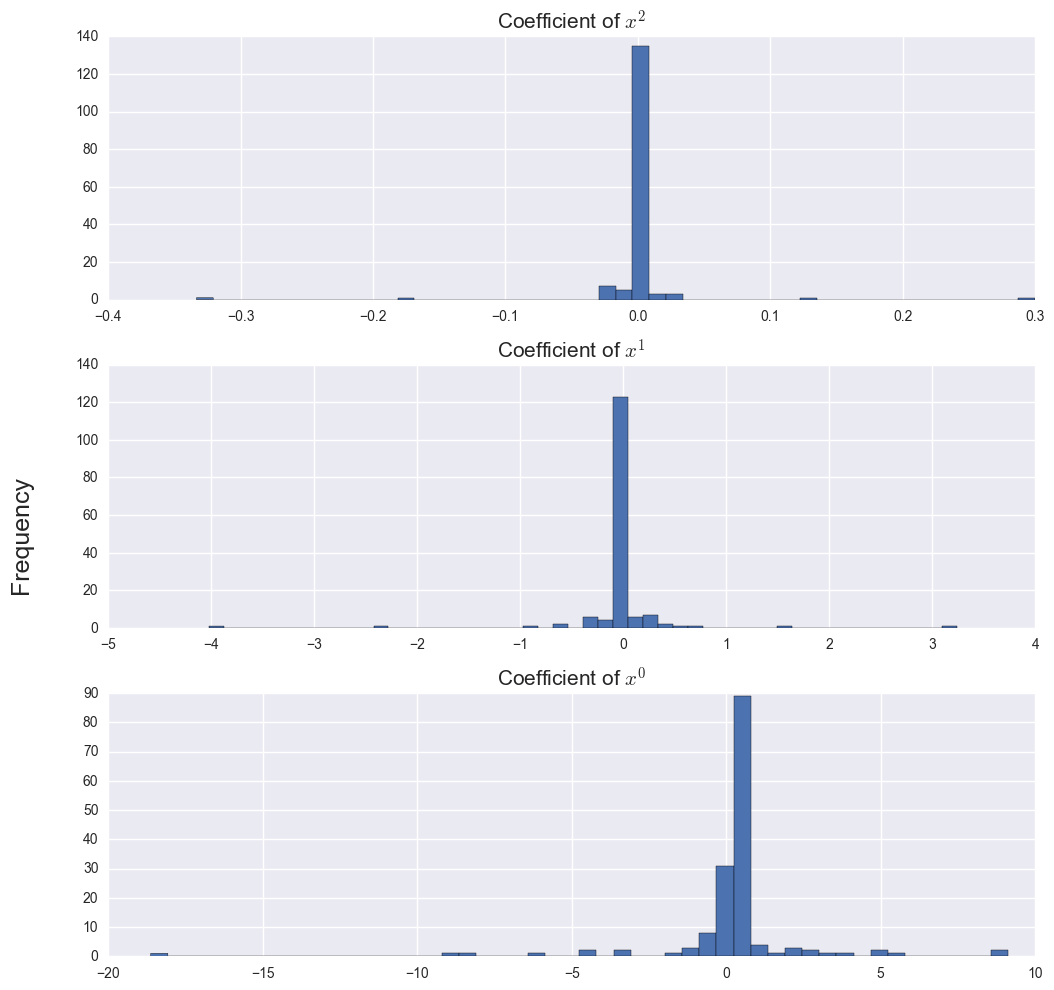

In [28]:
deg = 2
nbin = 50

fig, axes = pyplot.subplots(3,figsize=(10,10))
i = 0
for ax in axes:
        ax.hist(coeffs[:,i], nbin)
        ax.set_title("Coefficient of $x^{}$".format(deg - i), fontsize=15)
        i += 1
fig.text(-0.05, 0.5, "Frequency", fontsize=18, rotation="vertical")
fig.tight_layout()

In [10]:
coeffs = []
for k, v in storm_dict.items():
    c = poly_want_a_storm(v, degree=3, idx=2)
    coeffs.append(c)

coeffs = numpy.array(coeffs)

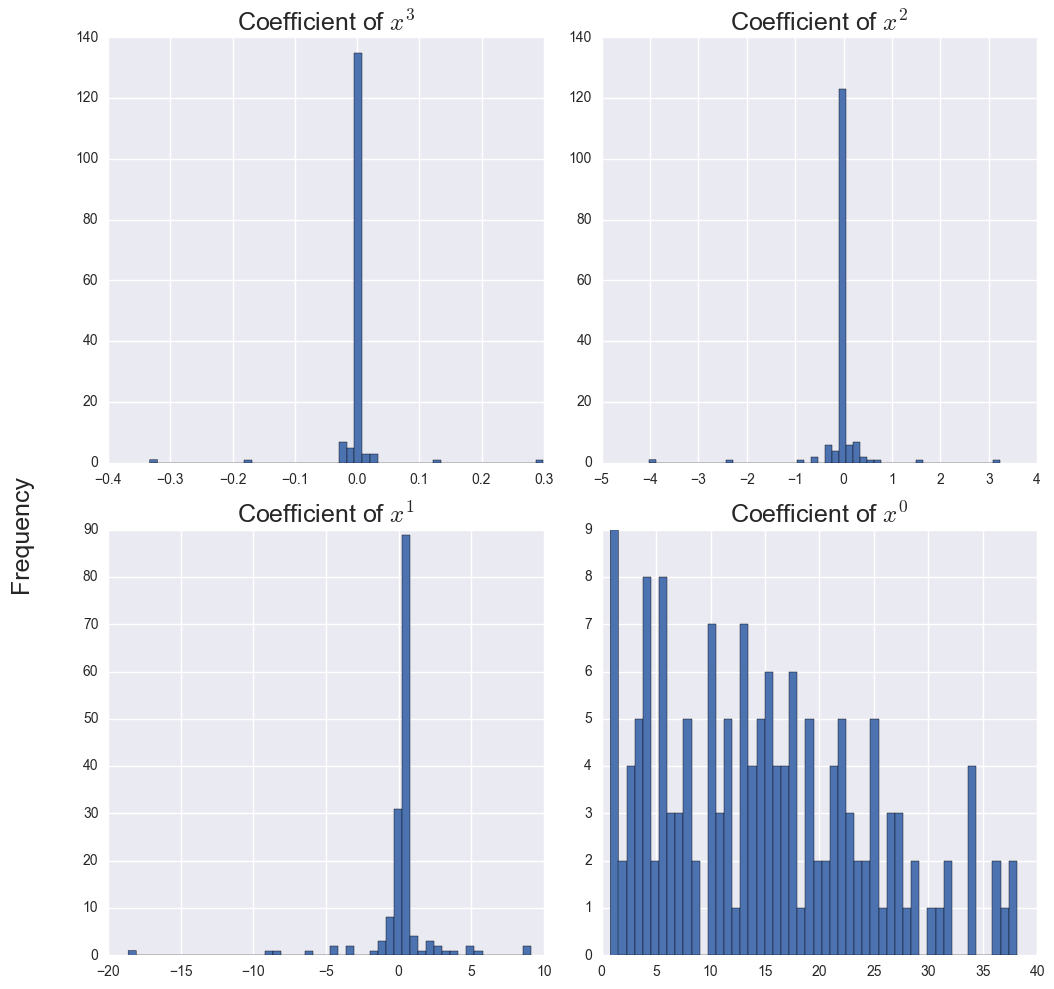

In [31]:
rows = 2
cols = 2
deg = 3
nbin = 50

fig, axes = pyplot.subplots(rows,cols, figsize=(10,10))
i = 0
for row in axes:
    for ax in row:
        ax.hist(coeffs[:,i], nbin)
        ax.set_title("Coefficient of $x^{}$".format(deg - i), fontsize=18)
        i += 1
fig.text(-0.05, 0.5, "Frequency", fontsize=18, rotation="vertical")
fig.tight_layout()

# Time Series and ARIMA Model

In [32]:
def date_convert(array):
    return datetime(*array)


def generate_ts(storm, data_idx=6):
    """
    Arguments
    ---------
    storm -- single storm from storm_dict
    """
    dates = [date_convert(x[:4]) for x in storm]
    data = [ float(x[data_idx]) for x in storm]

    return pandas.Series(data, dates).interpolate(method='time')

In [33]:
test_storm = storm_dict["ALBERTO2000"]
ts = generate_ts(test_storm)

In [34]:
arima = ARIMA(ts, (1,2,2)).fit()
arima.aic

483.441409091473

In [35]:
auto_arima.auto_arima(ts, (2,2,2))

((1, 2, 2), 486.80765766740353)

In [36]:
pool = Pool(4)

pdqs = []
max_idx = len(storm_dict)
winds = []
for key, values in storm_dict.items():
    ts = generate_ts(values)
    winds.append(ts)

result = pool.map(auto_arima.map_arima, winds)
pool.close()
pool.join()

/Users/edelsonc/miniconda3/lib/python3.5/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edelsonc/miniconda3/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:562: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/Users/edelsonc/miniconda3/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:536: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/edelsonc/miniconda3/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:537: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/edelsonc/miniconda3/lib/python3.5/site-packages/statsmodels/tools/numdiff.py:227: RuntimeWarning: invalid value encountered in add
  2./hess[i,j]
/Users/edelsonc/minicond

In [13]:
results = numpy.array(result)
numpy.save("arima_results", results)

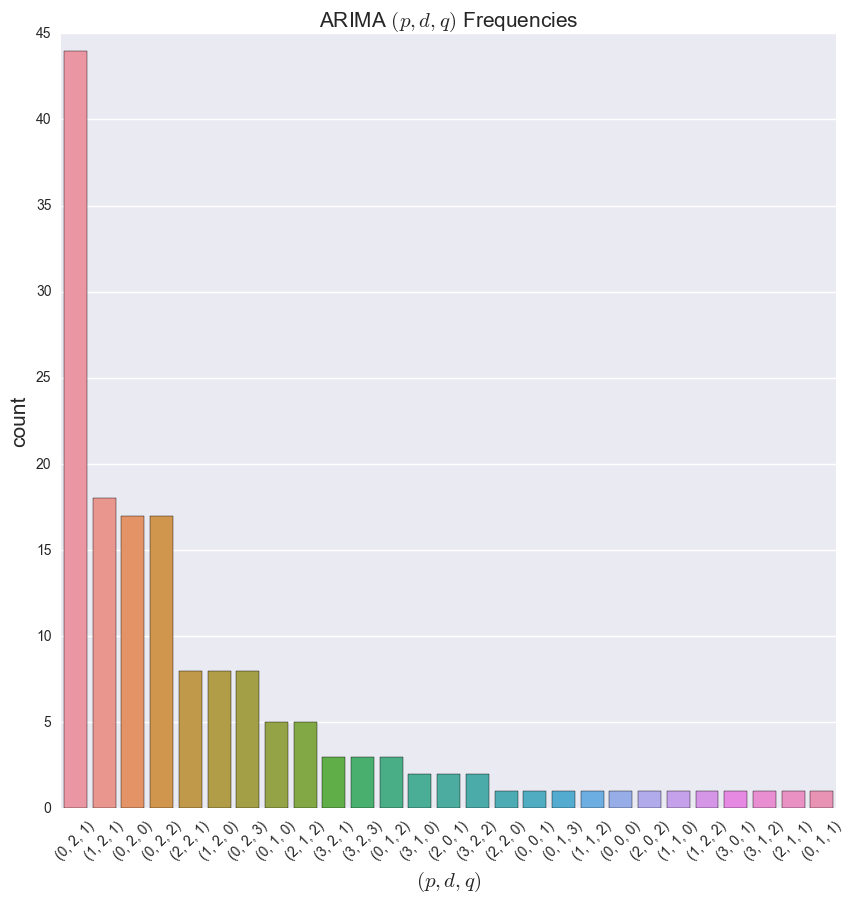

In [83]:
pdqs = [str( i[0]) for i in result]
pdqs_dict = {}
for pdq in pdqs:
    if pdq in pdqs_dict:
        pdqs_dict[pdq] += 1
    else:
        pdqs_dict[pdq] = 1

order = sorted(pdqs_dict, key=lambda x: pdqs_dict[x], reverse=True)

fig, axe = pyplot.subplots(figsize=(10,10))
seaborn.countplot(pdqs, order=order,ax=axe)
axe.set_ylabel("count", fontsize=15)
axe.set_xlabel("$(p,d,q)$", fontsize=15)
axe.set_xticklabels(axe.get_xticklabels(), rotation=45)
axe.set_title("ARIMA $(p,d,q)$ Frequencies", fontsize=15)
